# 1.0 Treinamento do Joaquim: DS Novato

In [1]:
import pandas as pd
import numpy as np

from sklearn import datasets as ds
from sklearn import model_selection as ms

## Dados sintéticos

In [2]:
# A função make_classification() é usada para criar um datasets com dados sintéticos uteis para estudarmos problemas 
# de regressão e nos retorna duas arrays, a primeira representa o conjunto de dados e possui dimensões dadas por 
# (n_samples, n_features) e a segunda array representa a classe que cada linha do primeiro conjunto representa.

X, y = ds.make_classification(
    
            n_samples=20000,       # Número de amostras
            n_features=2,          # Número de colunas do dataset
            n_informative=2,       # Número de features informativas (carregam informações uteis)
            n_redundant=0,         # Número de features redundantes (features muito correlacionadas)
            random_state=0         # Estado aleatório
)

In [3]:
# Dimensão do dataset (n_samples, n_features)
print(X.shape)

# Dataset gerado pela função make_classification()
X

(20000, 2)


array([[ 2.02287398,  0.28534593],
       [ 0.54989455,  0.70102121],
       [-0.65937627,  0.11606627],
       ...,
       [-0.08971485, -0.00977909],
       [ 1.71660807,  0.1355986 ],
       [ 0.34911178,  2.7185716 ]])

In [4]:
print(y.shape)

# Array que contém as classes de cada registro da array X
y

(20000,)


array([0, 0, 0, ..., 0, 0, 1])

Para facilitar a visualização do nosso conjunto de dados, vamos criar um dataframe.

In [5]:
df = pd.DataFrame(X)
df.shape

(20000, 2)

In [6]:
df.head()

,0,1
0,2.022874,0.285346
1,0.549895,0.701021
2,-0.659376,0.116066
3,0.967521,-1.060414
4,-1.796434,-2.093534


Antes de prosseguirmos vamos fazer uso da função `train_test_split()` do módulo `model_selection` da biblioteca `sklearn` para separar os dados.

```python
from sklearn import model_selection as ms

ms.train_test_split(X, y, test_size, random_state)
```

In [7]:
# Estamos usando a função train_test_split() para separar os dados de produção (teste), nesse caso
# o parâmetro `test_size=0.2` indica que estamos selecionando 20% dos registros para o nosso conjunto de produção
X, X_prod, y, y_prod = ms.train_test_split(X, y, test_size=0.2, random_state=0)

In [8]:
# No nosso conjunto original 'X' tínhamos 20_000 registros, como selecionamos 20% dos dados para o conjunto
# que simula o ambiente de produção `X_prod`, essa array terá 4000 registros
X_prod.shape

(4000, 2)

## Não há separação dos dados

In [9]:
from sklearn import tree as tr
from sklearn import metrics as mt

In [10]:
# Definição do modelo
model = tr.DecisionTreeClassifier(max_depth=38)  # O parametro max_depth indica a quantidade máxima 
                                                 # permitida para arvore crescer, esse parâmetro é capaz de
                                                 # causar overfitting
# Treinamento
model.fit(X,y)


# Classificação sobre os dados de treinamento
y_hat = model.predict(X)

# Calcula a acurácia do algoritmo treinado
acc = mt.accuracy_score(y, y_hat)

In [11]:
print(f'Accuracy Over Training: {acc}')

Accuracy Over Training: 1.0


A acurácia obtida pela nossa decision tree sobre o conjunto de treino foi de 100%

## Publicação do modelo em Produção

In [12]:
# Classifica os dados separados (que simulam um ambiente de produção)
y_hat_prod = model.predict(X_prod)

# Verifica a acurácia nos dados de produção
acc_prod = mt.accuracy_score(y_prod, y_hat_prod)

In [13]:
print(f'Accuracy Over Production: {acc_prod}')

Accuracy Over Production: 0.85075


Percebemos no ambiente de produção a nossa decision tree possui uma acurácia de 85%, o que representa uma queda de desempenho de 15% em relação ao treinamento. 

## Estratégia Treino-Teste

In [14]:
# Separa os dados em Treinamento e Teste
X_train, X_test, y_train, y_test = ms.train_test_split(X, y, test_size=0.2, random_state=0)

In [15]:
# Modelo treinando com os dados de treinamento
model = tr.DecisionTreeClassifier(max_depth=38)
model.fit(X_train, y_train)

# Classificando sobre os dados de teste
y_hat_test = model.predict(X_test)
acc_test = mt.accuracy_score(y_test, y_hat_test)

In [16]:
print(f'Accuracy Over Test: {acc_test}')

Accuracy Over Test: 0.851875


## Escolha os parâmetros do algoritmo

In [17]:
values = [i for i in range(1,60)]

test_score = list()

for i in values:
    # Treinando o modelo para profundidade 'max_depth=i'
    model = tr.DecisionTreeClassifier(max_depth=i)
    model.fit(X_train, y_train)
    
    # Classificação sobre o conjunto de teste
    y_hat_test = model.predict(X_test)
    acc_test = mt.accuracy_score(y_test, y_hat_test)
    
    test_score.append(acc_test)

In [18]:
import matplotlib.pyplot as plt

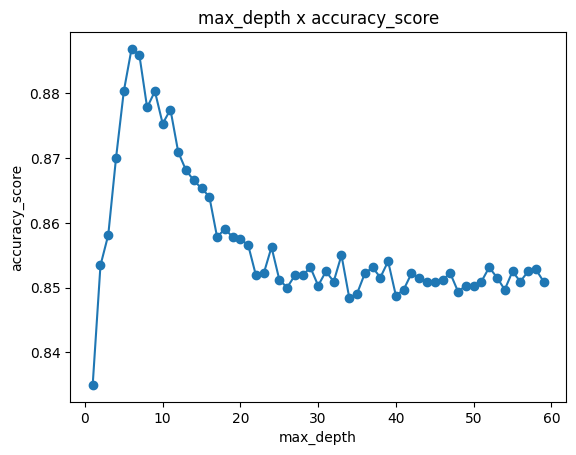

In [19]:
plt.plot(values, test_score, '-o', label='Test')

plt.title('max_depth x accuracy_score')
plt.xlabel('max_depth')
plt.ylabel('accuracy_score')

plt.show()

Pelo gráfico observamos que maior acurácia obtida pela nossa decision tree foi quando o valor do parâmetro `max_depth` era igual a 6.

## Publicação do algoritmo em Produção

O conjuntos de treino e teste já foram utilizados simultaneamente para escolhermos o melhor valor do parâmetro `max_depth`, então quando juntamos os 2 (usando a função `np.concatenate()`) existe um pequeno vazamento, porque na escolha do melhor valor de `max_depth` foi escolhido a partir do treinamento em cima desses conjuntos, portanto o algoritmo foi se optimizando em cima dos mesmos dados, causando o risco de superestimar o acurácia do nosso modelo.

In [20]:
# Modelo treinado
model_last = tr.DecisionTreeClassifier(max_depth=6)
model_last.fit( np.concatenate( (X_train, X_test) ),
                np.concatenate( (y_train, y_test) ) )

# Classificação sobre os dados de produção
y_hat_prod = model_last.predict(X_prod)
acc_prod = mt.accuracy_score(y_prod, y_hat_prod)


In [21]:
print(f'Accuracy Over Production: {acc_prod}')

Accuracy Over Production: 0.88175


# 2.0 Estratégia de Treino-Validação-Test

In [22]:
# Vamos a partir dos dados de treino (que já foram separados em treino e teste) vamos fazer um outra separação,
# dessa vez criando um novo conjunto de treino (um pouco menor que o anterior) e um conjunto de validação.

# Separação entre Treino e Validação
X_train, X_val, y_train, y_val = ms.train_test_split(X_train, y_train, test_size=0.2)

Vamos repetir o processo feito anteriormente para descobrir qual é o melhor valor do parâmetro `max_depth`. Dessa vez nós iremos verificar a acurácia para cada valor de `max_depth` usando o conjunto de validação `X_val`.

In [23]:
values = [i for i in range(1,60)]

val_score = list()

for i in values:
    # Treinando o modelo para profundidade 'max_depth=i'
    model = tr.DecisionTreeClassifier(max_depth=i)
    model.fit(X_train, y_train)
    
    # Classificação sobre o conjunto de validação
    y_hat_val = model.predict(X_val)
    acc_val = mt.accuracy_score(y_val, y_hat_val)
    
    val_score.append(acc_val)

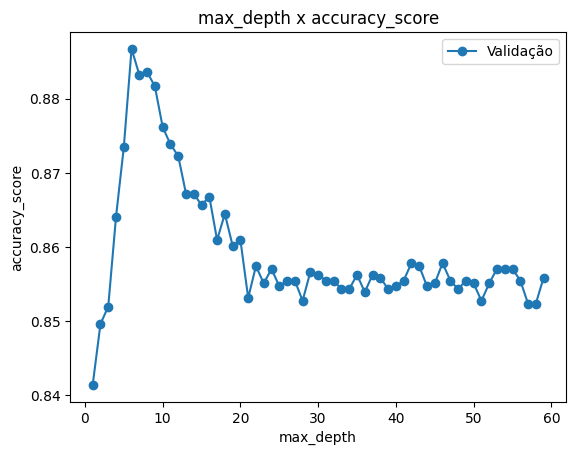

In [24]:
plt.plot(values, val_score, '-o', label='Validação')

plt.title('max_depth x accuracy_score')
plt.xlabel('max_depth')
plt.ylabel('accuracy_score')
plt.legend()

plt.show()

Dessa vez obtemos que o `max_depth=7` produz a melhor accuracy.

In [27]:
# Retreinando o algoritmo com 'max_depth' optimizado
model = tr.DecisionTreeClassifier(max_depth=7)
model.fit(X_train, y_train)

# Previsão sobre os dados de validação
y_hat_val = model.predict(X_val)
acc_val = mt.accuracy_score(y_val, y_hat_val)


print(f'Acuraccy Over Validation: {acc_val}')

Acuraccy Over Validation: 0.882421875


Durante o nosso treinamento o modelo já viu os conjunto de dados de Treinamento e Validação. Vamos agora testar a performance dele em um conjunto de dados que ele ainda não viu. Mas antes de testar a sua performance sobre o conjunto de Teste, vamos retreinar o nosso modelo mais uma vez usando todos os dados de Treinamento e Validação.

In [28]:
# Modelo treinado sobre training + validation
model_last = tr.DecisionTreeClassifier(max_depth=7)
model_last.fit( np.concatenate( (X_train, X_val) ),
                np.concatenate( (y_train, y_val) ))

# Testando a acurácia sobre o conjunto de teste
y_hat_test = model_last.predict(X_test)
acc_test = mt.accuracy_score(y_test, y_hat_test)


print(f'Accuracy Over Test: {acc_test}')

Accuracy Over Test: 0.8859375


In [29]:
# Testando o modelo para os dados de Produção
y_hat_prod = model_last.predict(X_prod)
acc_prod = mt.accuracy_score(y_prod, y_hat_prod)


print(f'Accuracy Over Prod: {acc_prod}')

Accuracy Over Prod: 0.87725
